# Surface water mass transformation (WMT) analysis of CMIP6 output using `xwmt`

This notebook demonstrates how to compute SWMT from scratch, using only the standard ocean surface variables that are typically archived for experiments contributed to the Coupled Model Intercomparison Project Phase 6 (CMIP6) archive.

## Import packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import xgcm
import xwmt
import xbudget
import os

# Optional (loading to memory and plotting) 
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import calendar
import warnings

In [2]:
print(
    'numpy version',np.__version__, '\nxarray version',xr.__version__,
    '\nxgcm version',xgcm.__version__, '\nxbudget version',xbudget.__version__,
    '\nxwmt version',xwmt.__version__,)

numpy version 2.4.2 
xarray version 2026.2.0 
xgcm version 0.9.0 
xbudget version 0.6.2 
xwmt version 0.2.0


## Loading a CMIP6 dataset

Update `rootdir` with your own dataset's path. All relevant variables will be loaded into `ds` and the (static) grid data will be loaded into a separate dataset. Note that the time period (`tprd`) is `'201001-201412'` such that only the last five years of the CM4 historical run are used. In order to include more years, you can use wildcard `*` for `tprd` instead.

In [3]:
rootdir = '/data_cmip6/CMIP6' # rootdir on GFDL PP/AN
activity_id = 'CMIP'
institution_id = 'NOAA-GFDL'
source_id = 'GFDL-CM4'
experiment_id = 'historical'
member_id = 'r1i1p1f1'
table_id = 'Omon'
grid_label = 'gn'
version = 'v20180701'
tprd = '201001-201412'
#tprd = '*'

ncdir = os.path.join(rootdir,activity_id,institution_id,source_id,experiment_id,member_id,table_id)

In [4]:
variables = [
    'tos', # surface temperature
    'sos', # surface salinity
    'hfds', # surface heat flux
    'sfdsi', # surface salinity flux (e.g. brine rejection)
    'wfo', # surface freshwater flux
]
chunks = {'time':1, 'x':-1, 'y':-1, 'xh':-1, 'yh':-1}

ds = xr.Dataset()
for var in variables:
    filepath = os.path.join(ncdir,var,grid_label,version)
    filename = '_'.join([var,table_id,source_id,experiment_id,member_id,grid_label,tprd])+'.nc'
    
    if os.path.isdir(filepath):
        print('Loading',filename)
        ds[var] = xr.open_mfdataset(filepath+'/'+filename, decode_times=True, chunks=chunks)[var]
    else:
        print('Path for',var,'does not exist. Skipping.')

Loading tos_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading sos_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading hfds_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Path for sfdsi does not exist. Skipping.
Loading wfo_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc


In [5]:
grid_ds = []
for var in ['areacello','deptho','basin']:
    filepath = os.path.join(ncdir.replace(table_id,'Ofx'),var,grid_label,version)
    filename = '_'.join([var,'Ofx',source_id,experiment_id,member_id,grid_label])+'.nc'
    
    if os.path.isdir(filepath):
        print('Loading',filename)
        grid_ds.append(xr.open_mfdataset(filepath+'/'+filename, decode_times=True, chunks=chunks))
    else:
        print('Path for',var,'does not exist. Skipping.')

Loading areacello_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc
Loading deptho_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc
Loading basin_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc


In [6]:
ds = xr.merge([ds, xr.merge(grid_ds[1:], compat="override")], compat="override")

# Area needs to be loaded seperately after renaming MOM6-specific dimension names (xh, yh) 
ds['areacello'] = grid_ds[0].areacello.rename({'xh': 'x', 'yh': 'y'})

In [7]:
# Add core coordinates of ocean_grid to ds
ds = ds.assign_coords({
    "areacello": xr.DataArray(ds["areacello"].values, dims=('y', 'x',)), # Required for area-integration
    "lon":       xr.DataArray(ds["lon"].values, dims=('y', 'x',)), # Required for calculating density if not already provided!
    "lat":       xr.DataArray(ds["lat"].values, dims=('y', 'x',)), # Required for calculating density if not already provided!
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'x',},
    'Y': {'center': 'y',},
}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, boundary={"X":"periodic", "Y":"extend"}, autoparse_metadata=False)

## Example plot of surface temperature

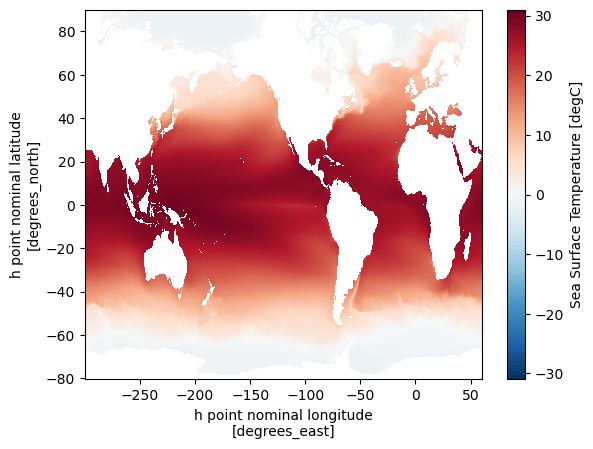

In [8]:
ds['tos'].mean('time').plot();

## Specify mask to apply for SWMT calculation

In [9]:
basin_name = 'pacific_tropc' # global, atlantic, indian, pacific, southern, arctic,
# atlantic_subpN,  pacific_tropc

bidx = [item.split('_')[0] for item in ds.basin.flag_meanings.split(' ')].index(basin_name.split('_')[0])

if basin_name=='global':
    mask = xr.where(ds.basin==bidx,0,1)
else:
    mask = ds.basin==bidx

In [10]:
if basin_name[-6:]=='_tropc':
    mask = mask & (ds["lat"]<=20) & (ds["lat"]>=-20)
if basin_name[-6:]=='_subtN':
    mask = mask & (ds["lat"]<=45) & (ds["lat"]>20)
if basin_name[-6:]=='_subpN':
    mask = mask & (ds["lat"]>45)
if basin_name[-6:]=='_subtS':
    mask = mask & (ds["lat"]>=-45) & (ds["lat"]<-20)

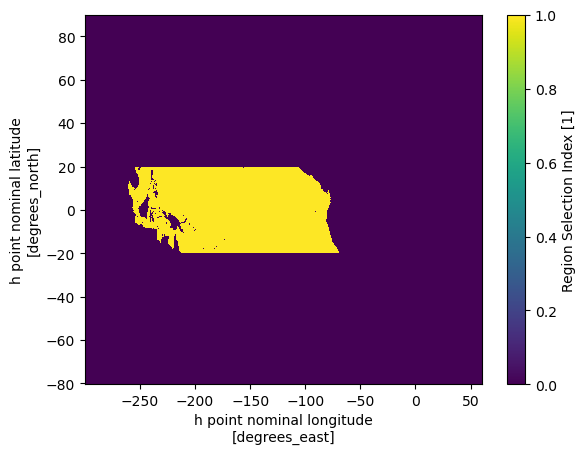

In [11]:
mask.plot();

## Construct xbudget dictionary

In [12]:
budgets_dict = {
    "mass": {},
    "heat": {"surface_lambda": "tos"},
    "salt": {"surface_lambda": "sos"}
}

In [13]:
cp = 3992.
rho_ref = 1035.
budgets_dict['heat']['rhs'] = {
    'var': None,
    'sum': {
        'var': None,
        'surface_exchange_flux_nonadvective': {
            'var': None,
            'product': {
                'var': None,
                'heat_tendency':'hfds',
                'area':'areacello'
            }
        },
        'surface_exchange_flux_advective': {
            'var': None,
            'product': {
                'var': None,
                'specific_heat_capacity': cp,
                'lambda_mass': 'tos',
                'mass_density_tendency': 'wfo',
                'area': 'areacello'
            }
        },
        'surface_ocean_flux_advective': {
            'var': None,
            'product': {
                'var': None,
                'sign': -1.,
                'specific_heat_capacity': cp,
                'lambda_mass': 'tos',
                'mass_density_tendency': 'wfo',
                'area': 'areacello'
            }
        }
    }
}
budgets_dict['salt']['rhs'] = {
    'var': None,
    'sum': {
        'var': None,
        'surface_exchange_flux_advective': {
            'var': None,
            'product': {
                'var': None,
                'unit_conversion': 0.001,
                'lambda_mass': 0.,
                'mass_density_tendency': 'wfo',
                'area': 'areacello'
            }
        },
        'surface_ocean_flux_advective': {
            'var': None,
            'product': {
                'var': None,
                'sign': -1.,
                'unit_conversion': 0.001,
                'lambda_mass': 'sos',
                'mass_density_tendency': 'wfo',
                'area': 'areacello'
            }
        }
    }
}

## Reconstruct budget terms using the 2D fields
xbudget.collect_budgets(grid._ds, budgets_dict)
simple_budget = xbudget.aggregate(budgets_dict) # aggregate to the root level

## Compute and visualize transformations

Method: default
[########################################] | 100% Completed | 5.24 sms
[########################################] | 100% Completed | 6.16 sms
[########################################] | 100% Completed | 5.51 sms
Method: xgcm


/work/hfd/.conda/envs/docs_env_xwmt/lib/python3.12/site-packages/xgcm/transform.py:491: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/docs_env_xwmt/lib/python3.12/site-packages/xgcm/transform.py:491: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/docs_env_xwmt/lib/python3.12/site-packages/xgcm/transform.py:491: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/docs_env_xwmt/lib/python3.1

[                                        ] | 0% Completed | 141.13 ms

/work/hfd/.conda/envs/docs_env_xwmt/lib/python3.12/site-packages/xgcm/transform.py:491: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(


[########################################] | 100% Completed | 55.65 s
[########################################] | 100% Completed | 111.54 s
[########################################] | 100% Completed | 87.19 s


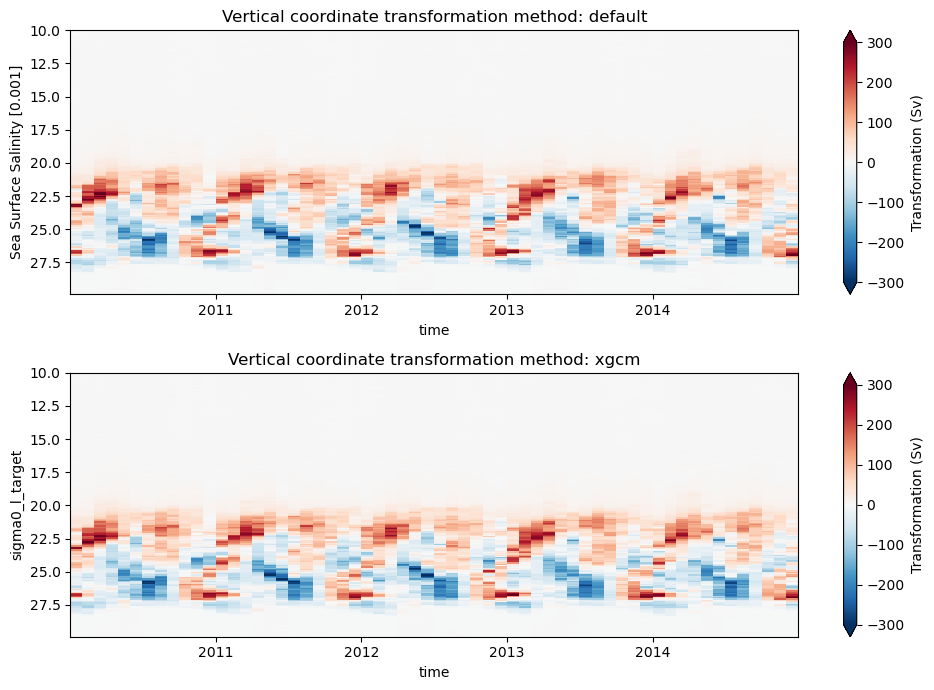

In [14]:
# The default method using `xhistogram` for area-integrated WMT calculations but `xgcm` for spatial transformations maps
plt.figure(figsize=(10,7))
for i, method in enumerate(["default", "xgcm"]):
    print(f"Method: {method}")
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        swmt = xwmt.WaterMassTransformations(grid, simple_budget, mask=mask, cp=cp, rho_ref=rho_ref, method=method)
        G = swmt.integrate_transformations("sigma0", bins=np.arange(10, 30, 0.1))
        with ProgressBar():
            G['surface_exchange_flux_nonadvective'].load()
            G['surface_exchange_flux_advective'].load()
            G['surface_ocean_flux_advective'].load()
        
        ax = plt.subplot(2,1,i+1)
        ((G['surface_exchange_flux_nonadvective'] +
         G['surface_exchange_flux_advective'] +
         G['surface_ocean_flux_advective']
        )/rho_ref*1.e-6).T.plot(
            ax=ax,cmap='RdBu_r',vmin=-300,vmax=300,yincrease=False,
            cbar_kwargs={'label': 'Transformation (Sv)'}
        );
    plt.title(f"Vertical coordinate transformation method: {method}")
plt.tight_layout()